In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [4]:
# DATA

# import

station_id=5001
file_path = os.path.join(f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# ambient direction
direction = new_data[['WIND_DIRECTION']]
print(direction)

# count the NaN values
nan_count_direction = direction['WIND_DIRECTION'].isna().sum()
print(nan_count_direction)
# there are 7156 NaN values
# fill them with backfill
direction = direction.fillna(method='bfill')
print(direction.isna().sum())

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=direction.index.min(), end=direction.index.max(), freq='5T')
missing_timestamps = complete_range.difference(direction.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
direction_incomplete = df_complete_range.merge(direction, left_index=True, right_index=True, how='left')
# print(direction_incomplete)
direction_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
direction_all = direction_incomplete.bfill()
print(direction_all)
direction_all.isna().sum() # okay

str(direction_all.index.dtype) # okay

parameter_type             WIND_DIRECTION
acquisition_timestamp                    
2020-10-13 10:20:00+00:00             NaN
2020-10-13 10:25:00+00:00           294.0
2020-10-13 10:30:00+00:00           282.0
2020-10-13 10:35:00+00:00           301.0
2020-10-13 10:40:00+00:00           289.0
...                                   ...
2023-05-31 21:35:00+00:00           156.0
2023-05-31 21:40:00+00:00           157.0
2023-05-31 21:45:00+00:00           162.0
2023-05-31 21:50:00+00:00            53.0
2023-05-31 21:55:00+00:00           212.0

[271508 rows x 1 columns]
7156
parameter_type
WIND_DIRECTION    0
dtype: int64
5112
                           WIND_DIRECTION
2020-10-13 10:20:00+00:00           294.0
2020-10-13 10:25:00+00:00           294.0
2020-10-13 10:30:00+00:00           282.0
2020-10-13 10:35:00+00:00           301.0
2020-10-13 10:40:00+00:00           289.0
...                                   ...
2023-05-31 21:35:00+00:00           156.0
2023-05-31 21:40:00+00:00        

C:\Users\aadit\AppData\Local\Temp\ipykernel_3740\26285305.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  direction = direction.fillna(method='bfill')


'datetime64[ns, UTC]'

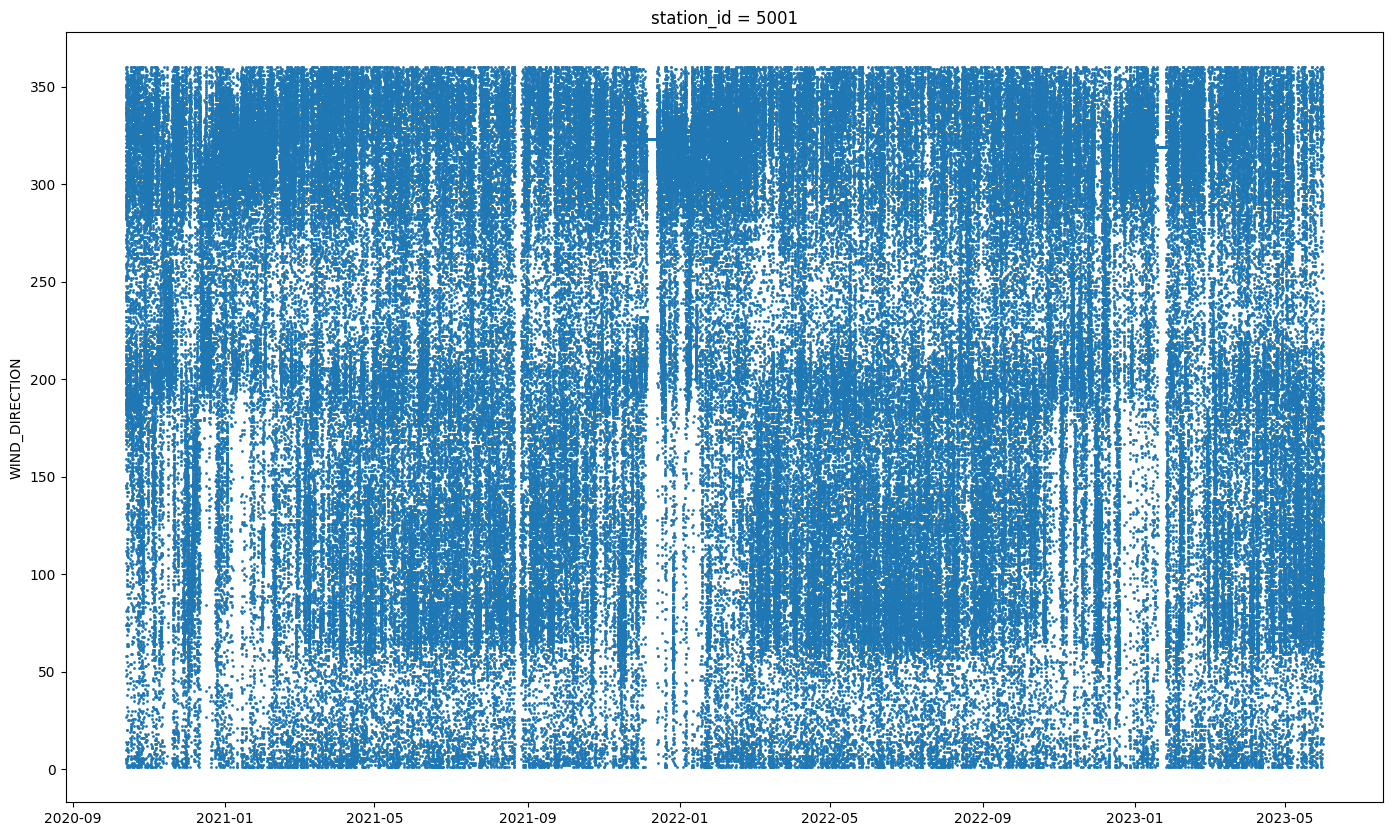

In [5]:
# plot 'WIND_DIRECTION'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(direction_all.index, direction_all['WIND_DIRECTION'],s=1)
ax.set_ylabel('WIND_DIRECTION')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           WIND_DIRECTION
2020-10-13 10:00:00+00:00      293.625000
2020-10-13 11:00:00+00:00      312.666667
2020-10-13 12:00:00+00:00      270.833333
2020-10-13 13:00:00+00:00      291.083333
2020-10-13 14:00:00+00:00      280.416667
...                                   ...
2023-05-31 17:00:00+00:00      197.000000
2023-05-31 18:00:00+00:00      220.166667
2023-05-31 19:00:00+00:00      185.250000
2023-05-31 20:00:00+00:00      161.833333
2023-05-31 21:00:00+00:00      176.250000

[23052 rows x 1 columns]


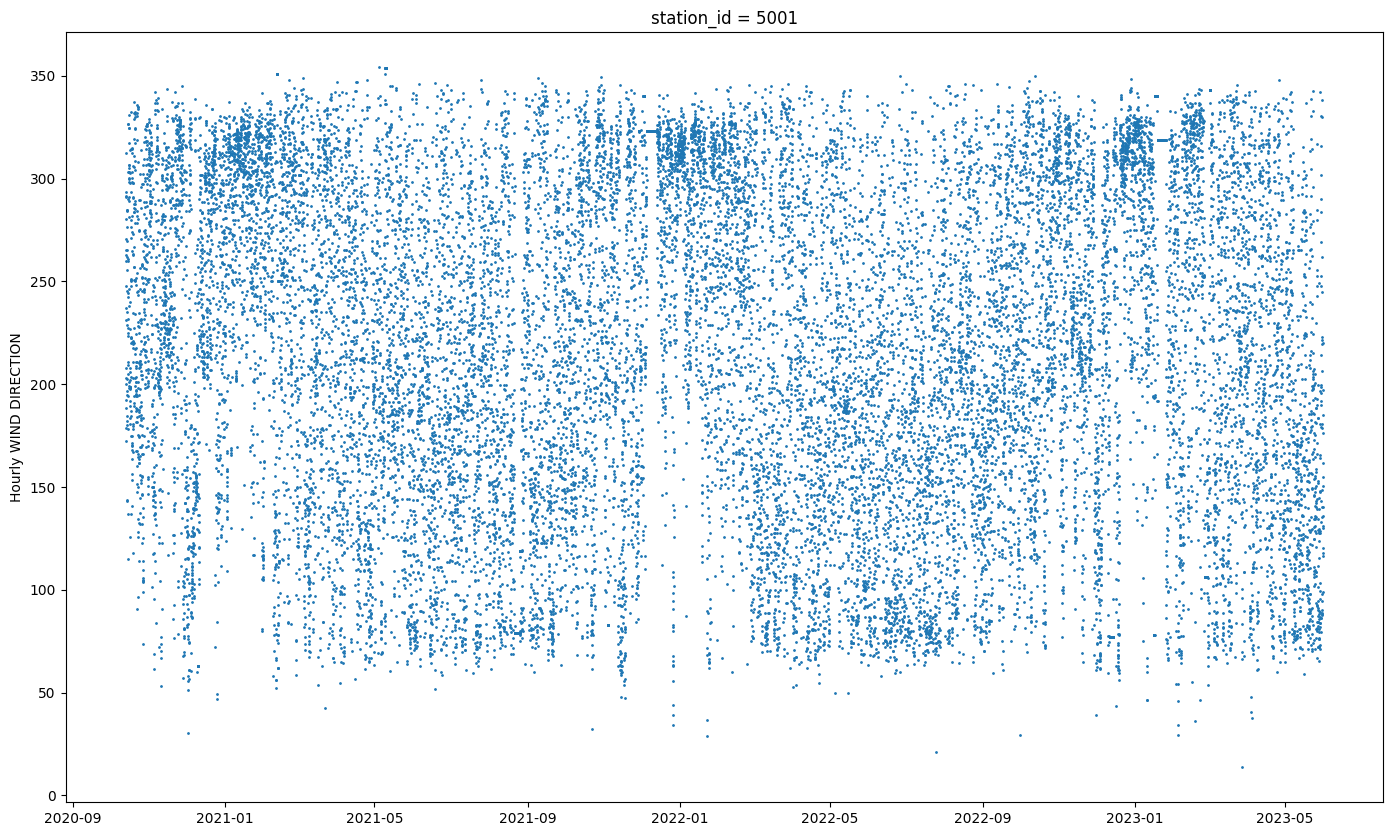

In [8]:
# hourly data
# sum the values for each hour and take the mean

str(direction_all.index.dtype) # okay
direction_hourly = direction_all.resample('H').mean()
print(direction_hourly)

# plot hourly 'WIND_DIRECTION'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(direction_hourly.index, direction_hourly['WIND_DIRECTION'],s=1)
ax.set_ylabel('Hourly WIND DIRECTION')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

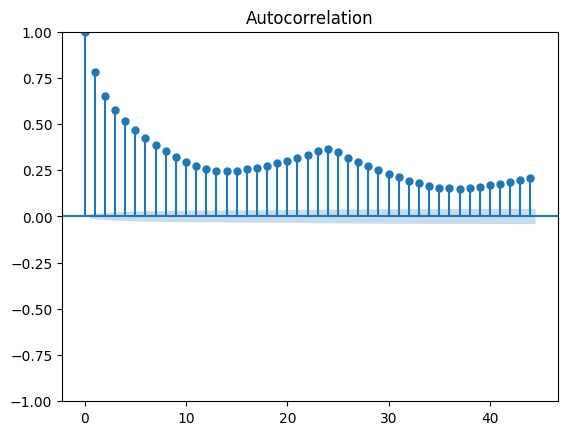

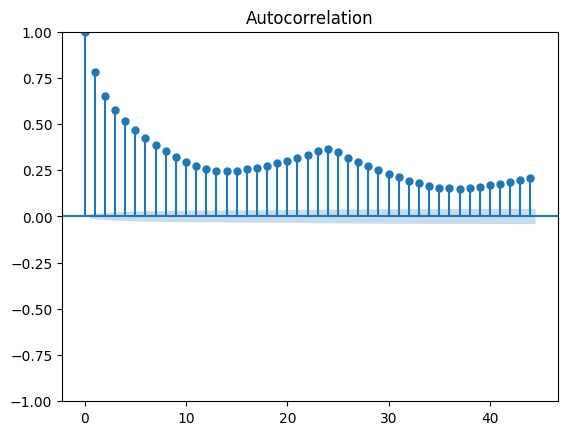

In [9]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(direction_hourly['WIND_DIRECTION'])

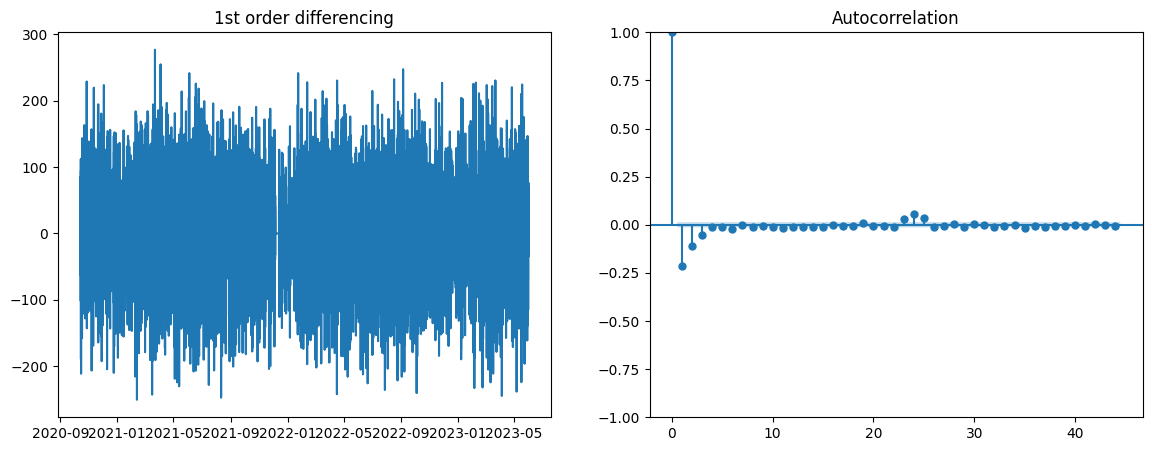

In [10]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(direction_hourly['WIND_DIRECTION'].diff())

ax2 = f.add_subplot(122)
plot_acf(direction_hourly['WIND_DIRECTION'].diff().dropna(), ax=ax2)
plt.show()


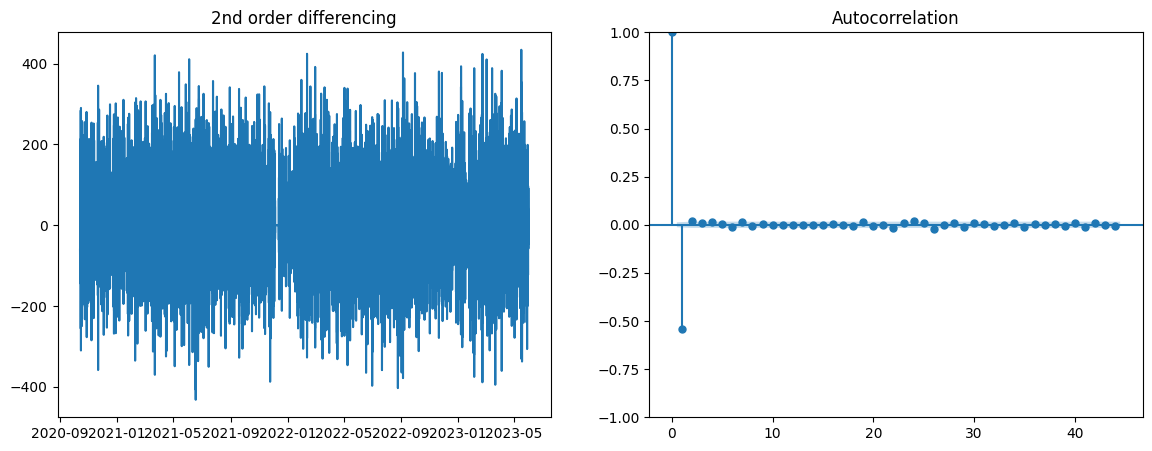

In [11]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(direction_hourly['WIND_DIRECTION'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(direction_hourly['WIND_DIRECTION'].diff().diff().dropna(), ax=ax2)
plt.show()

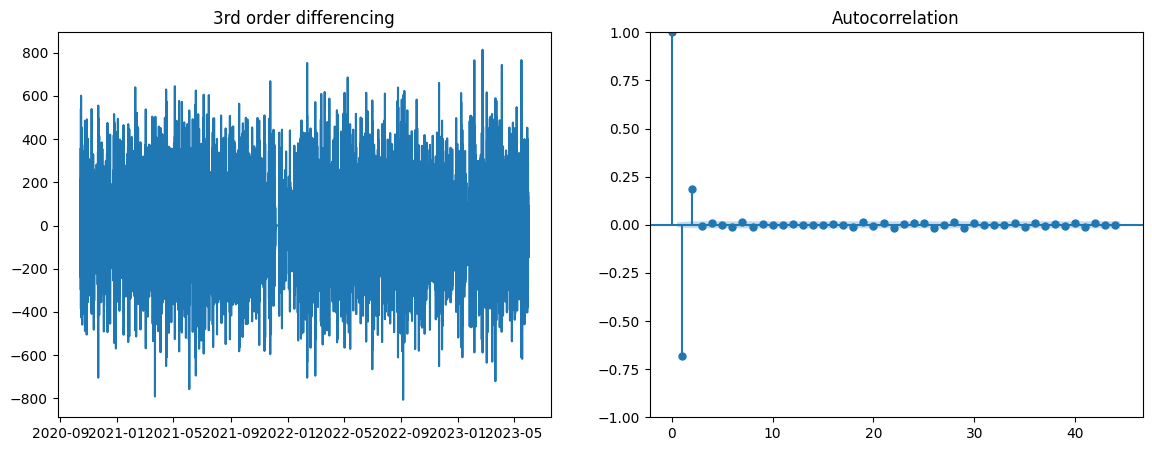

In [12]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(direction_hourly['WIND_DIRECTION'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(direction_hourly['WIND_DIRECTION'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencind, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(direction_hourly['WIND_DIRECTION'].dropna())
print('original data p-value:', result[1])

result = adfuller(direction_hourly['WIND_DIRECTION'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(direction_hourly['WIND_DIRECTION'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(direction_hourly['WIND_DIRECTION'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 8.102396183394013e-22
1-diff data p-value: 0.0
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [14]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly ambient direction data
from pmdarima import auto_arima
stepwise_fit = auto_arima(direction_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=13.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=248391.448, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=247328.361, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=246810.423, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=248389.448, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=245103.172, Time=3.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=244996.054, Time=7.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=246726.727, Time=0.85 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=244923.814, Time=11.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=246391.134, Time=1.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=244969.354, Time=17.77 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=246245.953, Time=1.33 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=244926.558, Time=14.18 sec
 ARIMA(3,1,1)(

                               SARIMAX Results                                
Dep. Variable:         WIND_DIRECTION   No. Observations:                23052
Model:                 ARIMA(3, 1, 2)   Log Likelihood             -122448.473
Date:                Sat, 18 May 2024   AIC                         244908.945
Time:                        23:00:04   BIC                         244957.218
Sample:                    10-13-2020   HQIC                        244924.631
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0470      0.082     12.789      0.000       0.887       1.207
ar.L2         -0.2239      0.052     -4.281      0.000      -0.326      -0.121
ar.L3          0.0302      0.010      3.150      0.0

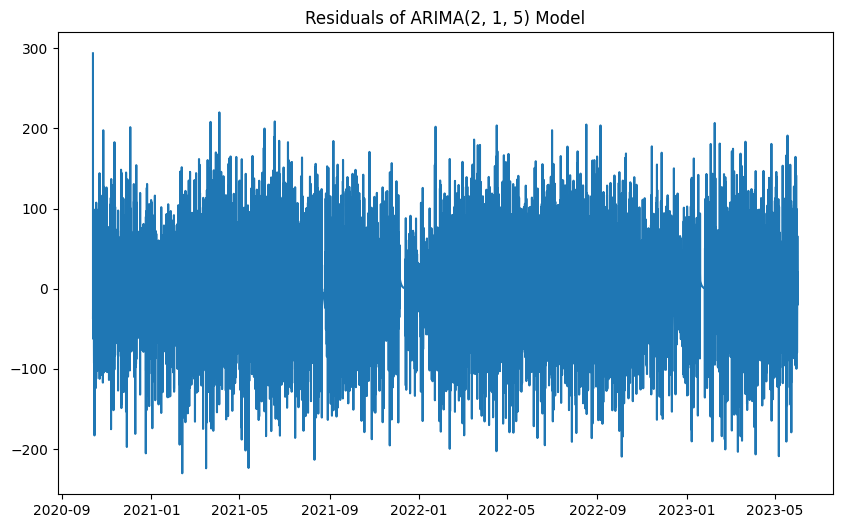

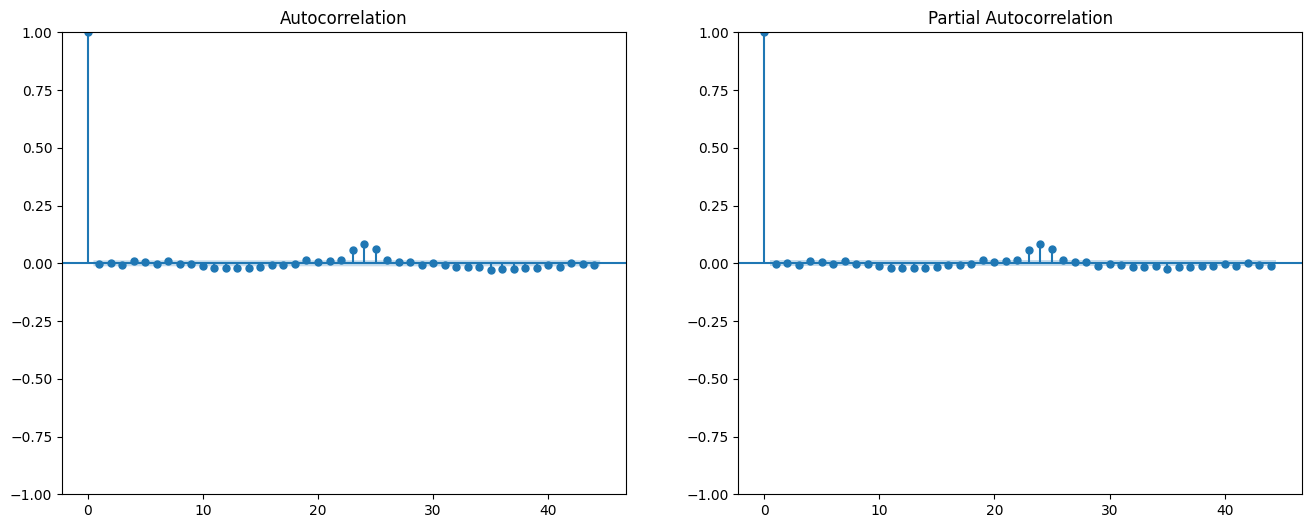

In [15]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(direction_hourly, order=(3,1,2))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{2,1,5} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

        Order            AIC            BIC
90  (5, 0, 1)  244867.138713  244931.502776
39  (2, 0, 3)  244874.017833  244930.336388
59  (3, 0, 5)  244876.437002  244956.892081
58  (3, 0, 4)  244877.413886  244949.823456
77  (4, 0, 5)  244881.467572  244969.968158
Best ARIMA order: (5, 0, 1)
                               SARIMAX Results                                
Dep. Variable:         WIND_DIRECTION   No. Observations:                23052
Model:                 ARIMA(5, 0, 1)   Log Likelihood             -122425.569
Date:                Sat, 18 May 2024   AIC                         244867.139
Time:                        23:19:46   BIC                         244931.503
Sample:                    10-13-2020   HQIC                        244888.053
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.97

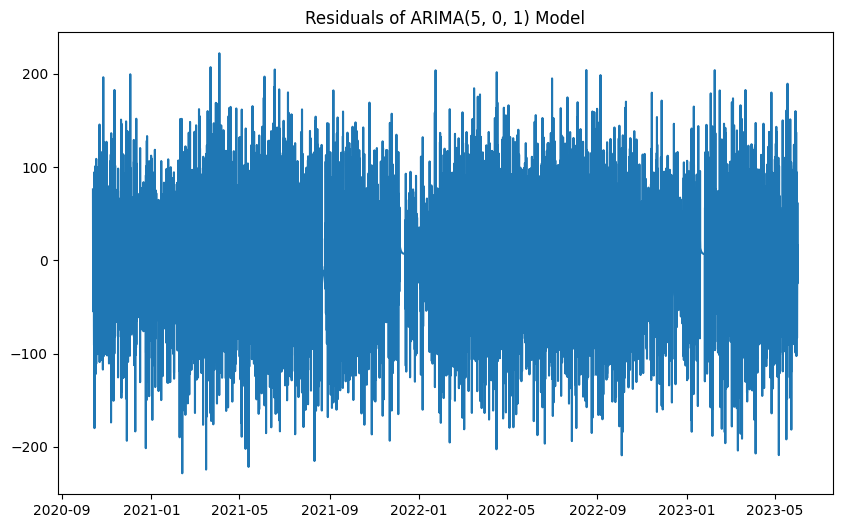

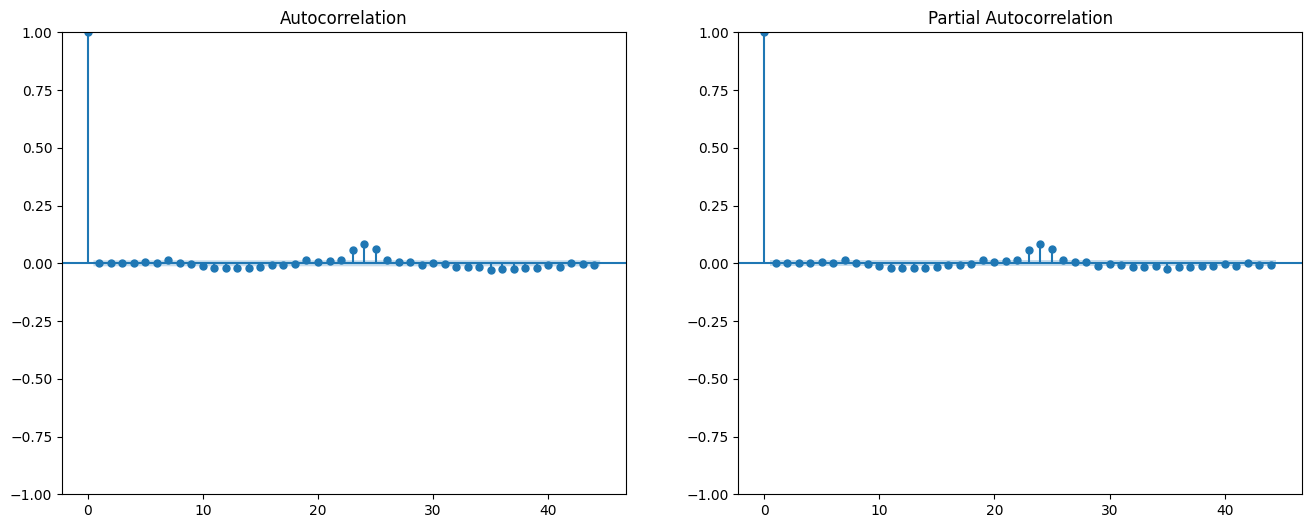

In [16]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(direction_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(direction_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()